In [1]:
"""
Notebook for the Meta-Learning sub-task of the SemEval2019 Task on "Hyperpartisan News Detection".
"""
TRAIN_DATASET_PATH = '../meta-learning-task/pan19-hyperpartisan-news-detection-by-article-meta-training-dataset-2019-02-04/'
GROUND_TRUTH_PATH  = '../meta-learning-task/pan19-hyperpartisan-news-detection-by-article-meta-training-dataset-2019-02-04/ground-truth/'

In [2]:
import os
import csv

data = dict()

for file in os.listdir(TRAIN_DATASET_PATH):
    if file.endswith('.txt'):
        with open(TRAIN_DATASET_PATH + file) as in_file:
            reader = csv.reader(in_file, delimiter=' ') ## csv with space delimiters
            data = {row[0]: [(w == 'true') for w in row[1:]] for row in reader}

In [3]:
truth = dict()

for file in os.listdir(GROUND_TRUTH_PATH):
    if file.endswith('.txt'):
        with open(GROUND_TRUTH_PATH + file) as in_file:
            reader = csv.reader(in_file, delimiter=' ') ## csv with space delimiters
            truth = {row[0]: (row[1] == 'true') for row in reader}
            
assert len(data) == len(truth)

In [4]:
import numpy as np

X = np.array([data[key] for key in sorted(data.keys())], dtype=np.bool)
y = np.array([truth[key] for key in sorted(data.keys())], dtype=np.bool)

## Add column with majority vote
X_vote = np.average(X, axis=1)
X_vote = np.reshape(X_vote, X_vote.shape + (1,))
X_vote = np.concatenate((X, X_vote), axis=1)

print('X.shape: {} ; X_vote.shape: {}'.format(X.shape, X_vote.shape))

## Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vote, y, test_size=0.2, stratify=y)

X.shape: (420, 42) ; X_vote.shape: (420, 43)


In [5]:
from sklearn.metrics import classification_report, accuracy_score

## Same function as baseline provided by SemEval
#majority_vote = lambda x: sum(x) >= ((len(x) - 1) / 2)
def majority_vote(x):
    return sum(x) >= ((len(x) - 1) / 2) if len(x) > 1 else x[0]

y_pred = [majority_vote(x) for x in X]
y_test_pred = [majority_vote(x) for x in X_test]
y_train_pred = [majority_vote(x) for x in X_train]

print('\n** Majority Vote Performance **\n')
print('Accuracy on whole dataset:\t', accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

print('Accuracy on test dataset:\t', accuracy_score(y_test, y_test_pred))
#print(classification_report(y_test, y_test_pred))

print('Accuracy on train dataset:\t', accuracy_score(y_train, y_train_pred))
#print(classification_report(y_train, y_train_pred))


** Majority Vote Performance **

Accuracy on whole dataset:	 0.8214285714285714
              precision    recall  f1-score   support

       False       0.83      0.81      0.82       210
        True       0.82      0.83      0.82       210

   micro avg       0.82      0.82      0.82       420
   macro avg       0.82      0.82      0.82       420
weighted avg       0.82      0.82      0.82       420

Accuracy on test dataset:	 0.8214285714285714
Accuracy on train dataset:	 0.8214285714285714


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rf_clf = RandomForestClassifier(
    n_estimators=100, min_samples_leaf=3, random_state=42 ## min_samples_leaf=3 ?
)

## Train and cross-validate with 5 folds
cv = cross_validate(rf_clf, X_vote, y, cv=10, return_train_score=True, scoring='accuracy')
rf_cv_acc = sum(cv['test_score']) / len(cv['test_score'])

print('CV Test score:', rf_cv_acc)
print('CV Test scores:', cv['test_score'])

print('CV Train score:', sum(cv['train_score']) / len(cv['train_score']))
print('CV Train scores:', cv['train_score'])

CV Test score: 0.8547619047619047
CV Test scores: [0.92857143 0.73809524 0.9047619  0.83333333 0.80952381 0.9047619
 0.88095238 0.95238095 0.80952381 0.78571429]
CV Train score: 0.8973544973544975
CV Train scores: [0.88888889 0.9021164  0.8968254  0.8994709  0.9047619  0.89153439
 0.8968254  0.8968254  0.8994709  0.8968254 ]


In [7]:
rf_clf.fit(X_train, y_train)
print('Accuracy score:', rf_clf.score(X_test, y_test))

rf_clf.feature_importances_

Accuracy score: 0.8690476190476191


array([0.00755584, 0.00837734, 0.00380734, 0.0283782 , 0.02879581,
       0.02342993, 0.01311767, 0.00673959, 0.02087136, 0.01571301,
       0.11383597, 0.0087804 , 0.00815595, 0.069083  , 0.06569422,
       0.00756008, 0.01760769, 0.02977459, 0.00447212, 0.00794147,
       0.02411894, 0.0457155 , 0.0066209 , 0.01216098, 0.00469378,
       0.00312457, 0.05913161, 0.00789109, 0.04907702, 0.01056021,
       0.00781031, 0.0088287 , 0.00741255, 0.01437422, 0.0054552 ,
       0.0074691 , 0.00811127, 0.00295052, 0.00358573, 0.00285878,
       0.01101683, 0.04088729, 0.16645331])

In [8]:
from sklearn import tree
from graphviz import Source
import random

dt = random.choice(rf_clf.estimators_)
graph = Source( tree.export_graphviz(dt, out_file=None) )

## Save DT Render to file
#graph.format = 'png'
#graph.render('dt_render', view=True)

#graph

In [9]:
import pickle

pickle.dump(rf_clf, open('../meta-learning-task/RF_meta-learning.pickle', 'wb'))

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
## Each team's system is a column in X
## Check which are best performing

accs = list()
for i in range(X.shape[1]):
    accuracy = accuracy_score(y, X[:,i].round())
    accs.append(accuracy)
    print('{:2} - Acc: {:.3} - P: {:.3} - R: {:.3} - F1: {:.3}'.format(
        i, accuracy_score(y, X[:,i].round()), precision_score(y, X[:,i].round()),
        precision_score(y, X[:,i].round()), f1_score(y, X[:,i].round()))
    )
    
mean_accs = sum(accs) / len(accs)
print('\nMean accuracy:', mean_accs)

 0 - Acc: 0.545 - P: 0.535 - R: 0.535 - F1: 0.603
 1 - Acc: 0.581 - P: 0.693 - R: 0.693 - F1: 0.409
 2 - Acc: 0.614 - P: 0.568 - R: 0.568 - F1: 0.712
 3 - Acc: 0.726 - P: 0.799 - R: 0.799 - F1: 0.688
 4 - Acc: 0.745 - P: 0.719 - R: 0.719 - F1: 0.76
 5 - Acc: 0.771 - P: 0.875 - R: 0.875 - F1: 0.735
 6 - Acc: 0.702 - P: 0.754 - R: 0.754 - F1: 0.668
 7 - Acc: 0.605 - P: 0.562 - R: 0.562 - F1: 0.706
 8 - Acc: 0.748 - P: 0.838 - R: 0.838 - F1: 0.709
 9 - Acc: 0.719 - P: 0.725 - R: 0.725 - F1: 0.715
10 - Acc: 0.814 - P: 0.808 - R: 0.808 - F1: 0.816
11 - Acc: 0.464 - P: 0.465 - R: 0.465 - F1: 0.468
12 - Acc: 0.705 - P: 0.807 - R: 0.807 - F1: 0.646
13 - Acc: 0.793 - P: 0.812 - R: 0.812 - F1: 0.786
14 - Acc: 0.807 - P: 0.856 - R: 0.856 - F1: 0.793
15 - Acc: 0.726 - P: 0.739 - R: 0.739 - F1: 0.719
16 - Acc: 0.707 - P: 0.804 - R: 0.804 - F1: 0.652
17 - Acc: 0.774 - P: 0.758 - R: 0.758 - F1: 0.781
18 - Acc: 0.645 - P: 0.592 - R: 0.592 - F1: 0.725
19 - Acc: 0.612 - P: 0.576 - R: 0.576 - F1: 0.686
2

In [11]:
## Remove worst classifier/col one classifier/col at a time, plot majority vote for each state of the dataset
from sklearn.metrics import f1_score, accuracy_score
accs = np.array(accs)

accs_over_removals = list()
f1_over_removals   = list()

used_columns = [True for _ in range(X.shape[1])]

for i in np.argsort(accs):
    X_tmp = X[:,used_columns]
    y_votes = [majority_vote(x) for x in X_tmp]
    a = accuracy_score(y, y_votes) * 100
    f = f1_score(y, y_votes) * 100
    print('Top-{:2}; Col: {:2}; Acc/F1: {:.3} / {:.3}'.format(X_tmp.shape[1], i, a, f))
    
    accs_over_removals.append(a)
    f1_over_removals.append(f)
    used_columns[i] = False

Top-42; Col: 11; Acc/F1: 82.1 / 82.3
Top-41; Col: 22; Acc/F1: 82.6 / 83.0
Top-40; Col: 27; Acc/F1: 82.6 / 82.6
Top-39; Col:  0; Acc/F1: 82.4 / 82.5
Top-38; Col: 39; Acc/F1: 82.4 / 82.2
Top-37; Col: 25; Acc/F1: 83.1 / 83.2
Top-36; Col:  1; Acc/F1: 82.4 / 82.2
Top-35; Col: 37; Acc/F1: 83.1 / 83.1
Top-34; Col: 24; Acc/F1: 81.7 / 81.4
Top-33; Col: 38; Acc/F1: 81.4 / 81.2
Top-32; Col:  7; Acc/F1: 81.7 / 81.3
Top-31; Col: 19; Acc/F1: 81.4 / 81.1
Top-30; Col:  2; Acc/F1: 81.2 / 80.6
Top-29; Col: 40; Acc/F1: 81.2 / 80.7
Top-28; Col: 32; Acc/F1: 81.2 / 80.4
Top-27; Col: 18; Acc/F1: 81.2 / 80.7
Top-26; Col: 30; Acc/F1: 81.7 / 80.9
Top-25; Col: 33; Acc/F1: 81.4 / 80.8
Top-24; Col: 23; Acc/F1: 81.0 / 79.9
Top-23; Col: 36; Acc/F1: 81.0 / 80.2
Top-22; Col: 31; Acc/F1: 81.0 / 80.0
Top-21; Col: 41; Acc/F1: 81.7 / 81.0
Top-20; Col: 35; Acc/F1: 81.0 / 79.8
Top-19; Col:  6; Acc/F1: 82.1 / 81.3
Top-18; Col: 12; Acc/F1: 81.7 / 80.5
Top-17; Col: 16; Acc/F1: 82.4 / 81.6
Top-16; Col: 29; Acc/F1: 81.7 / 80.5
T

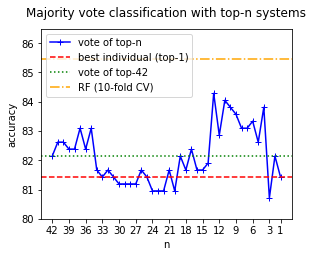

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Majority vote classification with top-n systems', y=1.03)

#plt.plot(f1_over_removals, 'r-+')
plt.plot(accs_over_removals, 'b-+', label='vote of top-n')

x_ticks = [n for n in range(len(accs_over_removals)) if n % 3 == 0 or n == 41]
plt.xticks(ticks=x_ticks, labels=[len(accs_over_removals) - i for i in x_ticks])
plt.ylim(80, 86.5)

plt.axhline(y=accs.max() * 100, label='best individual (top-1)', color='r', linestyle='--')
plt.axhline(y=accs_over_removals[0], label='vote of top-42', color='g', linestyle=':')
plt.axhline(y=rf_cv_acc * 100, label='RF (10-fold CV)', color='orange', linestyle='-.')

plt.xlabel('n')
plt.ylabel('accuracy')
plt.legend(loc='best')

fig = plt.gcf()
fig.set_size_inches(4.5, 3.5)
plt.savefig('../imgs/meta-learning.png', dpi=300, bbox_inches='tight')